In [206]:
%%time
# Imports
from utils import *

CPU times: total: 0 ns
Wall time: 0 ns


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , 'tweets_small.txt')
user = []
ts = []
tweets = []

with open(path , 'r') as in_file:
    csv_reader = csv.reader(in_file , delimiter = ",")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        tweets.append(line[2])

# **01 - BASIC STATS**
### **Question - 1**

In [3]:
%%time
# Remove None tweets - there are a few
tweets_non_null = [tweet for tweet in tweets if tweet!="None"]
tweets_null = [tweet for tweet in tweets if tweet=="None"]

# Duplicate Identification
tweets_non_null_2 = np.sort(np.array(tweets_non_null))
duplicates = tweets_non_null_2[:-1][tweets_non_null_2[1:]==tweets_non_null_2[:-1]] # https://stackoverflow.com/questions/11528078/determining-duplicate-values-in-an-array

# Question - 1
print(f'The total number of tweets is {len(set(tweets_non_null))} with {len(set(duplicates))} occupying {len(duplicates)} places. {len(tweets_null)} records do not have tweet ID')

The total number of tweets is 15033548 with 5666 occupying 6839 places. 322 records do not have tweet ID


### **Question - 2**

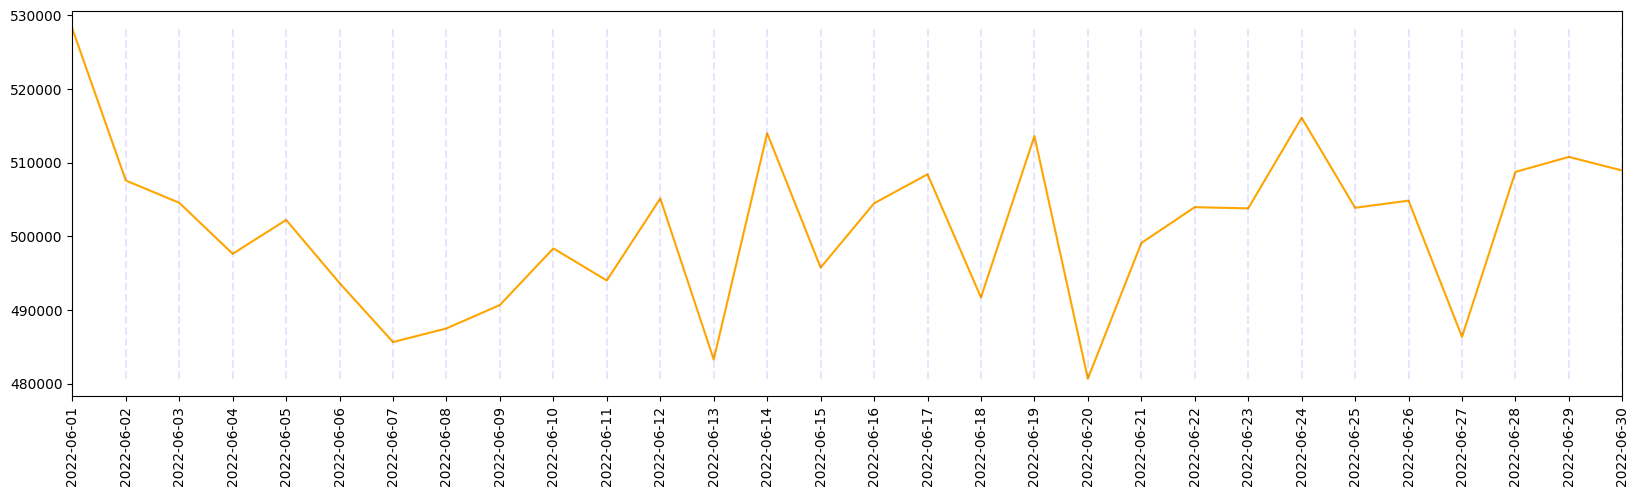

In [4]:
%%time
ts_convert = [datetime.datetime.fromtimestamp(int(dt)/1000) for dt in ts]

twt_df = pd.DataFrame(list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id'])
twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()

# QC
assert len(twt_df) == len(set(tweets_non_null)) , "length of db does not match"

# Correctness Check - one tweet cannot have more than 1 author or less than 1 author
assert twt_df.groupby('tweet_id').agg(num_auth = ('user','nunique')).reset_index().sort_values('num_auth' , ascending = False).iloc[0]['num_auth'] == 1 , 'tweet cannot have moree than one author'

# Create a date column
twt_df['ts_day'] = pd.to_datetime(twt_df['ts']).dt.date # https://www.geeksforgeeks.org/how-to-convert-datetime-to-date-in-pandas/

# Group at day level
twt_daily = twt_df.groupby('ts_day').agg(num_tweets = ('tweet_id','nunique'))

# Plot
fig , ax = plt.subplots(figsize = (20 , 5))
ax.plot(twt_daily['num_tweets'] , color = 'orange');
plt.xticks(rotation = 90);
ax.vlines(
    twt_daily.index , 
    ymin = min(twt_daily['num_tweets']) , 
    ymax = max(twt_daily['num_tweets']) ,
    color = 'blue' ,
    alpha = 0.1 ,
    ls = '--'
);
plt.xlim(min(twt_daily.index) , max(twt_daily.index));
plt.xticks(twt_daily.index);

**Comments**:<br/>
Tweets seem to be falling slightly on Mondays, which sort of makes sense as people resume work after the weekend.

### **Question - 3**

2.75
Correlation coefficient is 0.6266438946457623


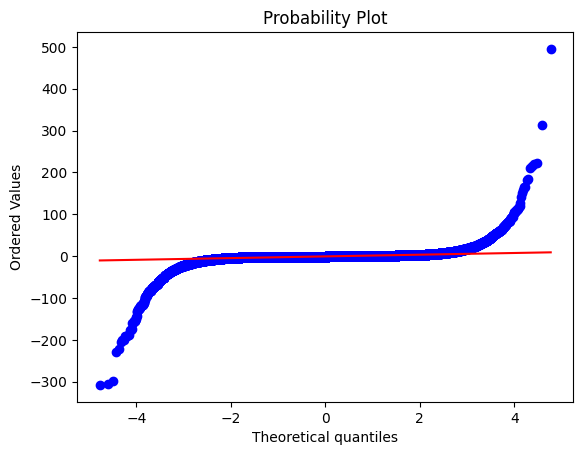

In [5]:
%%time
# Create a weekday-or-not column
twt_df['weekday'] = np.where(pd.to_datetime(twt_df['ts']).dt.day_of_week <= 4 , 1 , 0)

# Should be close to 22/8 = 2.75 if there's no real difference in the amount of tweets between weekends and weekdays
print(np.round(len(twt_df[twt_df['weekday'] == 1])/len(twt_df[twt_df['weekday'] == 0]) , 2))

# More Rigourous Testing is necessary
hypo_test_df = twt_df.pivot_table(
    index = ['user'] , 
    columns = ['weekday'] , 
    values = ['tweet_id' , 'ts_day'] , 
    aggfunc = 'nunique'
    ).reset_index().fillna(0)

# Reset the  column names
hypo_test_df.columns = ['user' , 'weekends' , 'weekdays' , 'weekend_tweets' , 'weekday_tweets']

# Collect average weekend and weekday tweets at user level
hypo_test_df['avg_weekend_tweets'] = hypo_test_df['weekend_tweets']/hypo_test_df['weekends']
hypo_test_df['avg_weekday_tweets'] = hypo_test_df['weekday_tweets']/hypo_test_df['weekdays']

hypo_test_df.fillna(0 , inplace = True)

# We will test if this difference is normal(-ish); that will allow us to conduct t-tests on the data 
hypo_test_df['mean_diff'] = hypo_test_df['avg_weekend_tweets'] - hypo_test_df['avg_weekday_tweets']


(osm, osr), (slope, intercept, r) = scipy.stats.probplot(hypo_test_df['mean_diff'] , plot = plt);
print(f'Correlation coefficient is {r}')


This doesn't look to be very normal. However, let us remind ourselves that with large N, t-test is not _that_ sensitive to non-normal data <br/>
Because of such large data, CLT will help in us being able to use a t-test! <br/>
**Reference**: https://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/


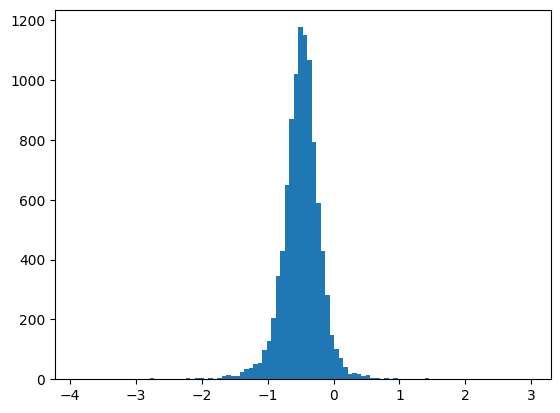

In [6]:
%%time
# Simulate CLT
X = np.array(hypo_test_df['mean_diff'])

sample_size = 100

N = 10000

collect = []

for _ in range(N):
    sample = [np.random.choice(X) for i in range(100)]
    sample_mean = np.mean(sample)
    collect.append(sample_mean)

fig , ax = plt.subplots()

ax.hist(collect , bins = 100);

# Lo and behold, it is normal - we can use a paired ttest (scipy.stats.ttest_rel)


In [7]:
%%time
# Standardize the data
avg_weekday_twt = (np.array(hypo_test_df['avg_weekday_tweets']) - np.mean(np.array(hypo_test_df['avg_weekday_tweets'])))/np.std(np.array(hypo_test_df['avg_weekday_tweets']))
avg_weekdend_twt = (np.array(hypo_test_df['avg_weekend_tweets']) - np.mean(np.array(hypo_test_df['avg_weekend_tweets'])))/np.std(np.array(hypo_test_df['avg_weekend_tweets']))

# Set up the Hypothesis test
# H0: There is not difference between the means
# Paired T Test
scipy.stats.ttest_rel(avg_weekday_twt , avg_weekdend_twt)

Ttest_relResult(statistic=2.654590994409255e-14, pvalue=0.9999999999999788)

**Such a high p-value says:**
1. There is definitely not enough evidence to reject the Null Hypothesis that the two means are equal.
2. The two datasets are most likely highly correlated; a correlation test would likely yield a very high coefficient

In [8]:
%%time
scipy.stats.pearsonr(avg_weekday_twt , avg_weekdend_twt)

PearsonRResult(statistic=0.7548022023741843, pvalue=0.0)

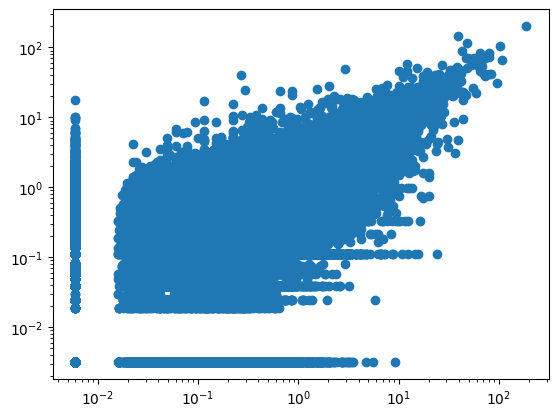

In [9]:
%%time
plt.scatter(avg_weekday_twt , avg_weekdend_twt);
plt.xscale('log');
plt.yscale('log');

**They appear to be roughly correlated, albeit not to a great degree (75%)**

### **Question - 4**

In [31]:
%%time
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

In [32]:
%%time
twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

In [81]:
%%time
twt_df_hr = twt_df.groupby(['hour' , 'dayofweek']).agg(num_tweets = ('tweet_id','nunique')).reset_index()

In [40]:
%%time
# Check
twt_df_hr.sum()

hour                                                       1932
dayofweek     FriMonSatSunThuTueWedFriMonSatSunThuTueWedFriM...
num_tweets                                             15033548
dtype: object

In [82]:
%%time
twt_df_hr_only = twt_df_hr.groupby('hour').agg(num_tweets_avg = ('num_tweets' , np.mean))

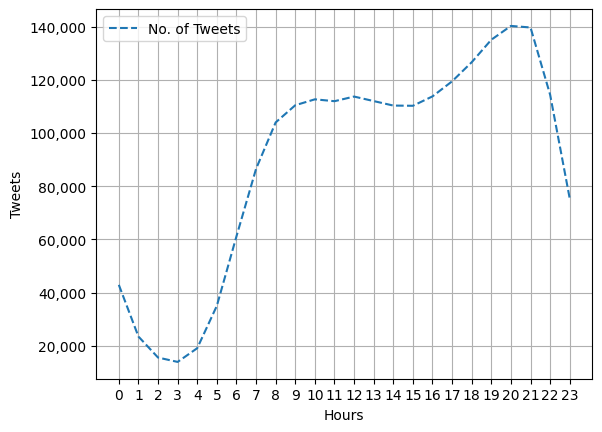

In [107]:
%%time
fig , ax = plt.subplots()

ax.plot(twt_df_hr_only , ls = '--' , label = 'No. of Tweets');
plt.xticks(twt_df_hr_only.index);
ax.grid();
ax.legend(loc = 'best');
ax.set_xlabel('Hours');
ax.set_ylabel('Tweets');
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))) #https://stackoverflow.com/questions/51734218/formatting-y-axis-matplotlib-with-thousands-separator-and-font-size

**Comment on Pattern** <br/>
Starting from 12 midnight, we see a decline in the number of tweets as more and more people go to bed. This number starts picking up after 2 AM - 3AM as people start getting up (remember there are a couple of timezones captured in this data). The number climbs sharply till about 8 AM, which is likely when most users clock in to their daily work/ school, (or start commuting to work/ school etc). Tweets stay plateaued at this range till around 3 PM, from where it starts hiking upwards again - people are liekly leaving work/ school at this time. Number continues to increase until roughly 10 PM at night, which is when we see a sharp decline, likely due to users retiring for the day/ going to bed. <br/>
As a bonus, let's look at the pattern over the days separately instead of averaging them

In [141]:
%%time
twt_df_2 = twt_df.copy()
twt_df_2['day_hr'] = twt_df_2['day']*100+twt_df_2['hour']
twt_df_3 = twt_df_2.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
twt_df_3['day_hr'] = twt_df_3['day_hr'].astype('str').str.zfill(4)

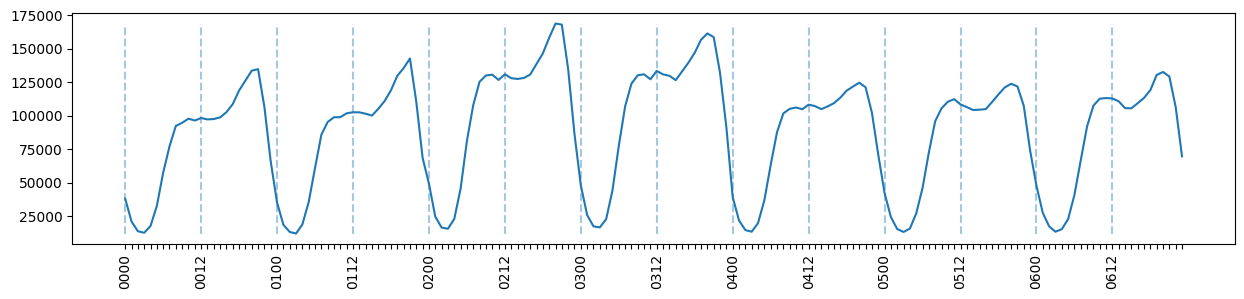

In [165]:
%%time
fig , ax = plt.subplots(figsize = (15 , 3))
ax.plot(twt_df_3.day_hr , twt_df_3.num_tweets);
#ax.grid();

plt.xticks(rotation = 90);

every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

ax.vlines(
    twt_df_3.day_hr[::12] , 
    ymin = twt_df_3.num_tweets.min() , 
    ymax = twt_df_3.num_tweets.max() ,
    alpha = 0.4 , ls = '--');

**It seems like although the hourly pattern is mostly preserved in the number of tweets, Wednesdays and Thursdays see on average the highest volume of tweets** 

# **02 - USERS**
### **Question - 1**

In [170]:
%%time
twt_df_usr = twt_df.groupby('user').agg(num_twt = ('tweet_id' , 'nunique')).reset_index()

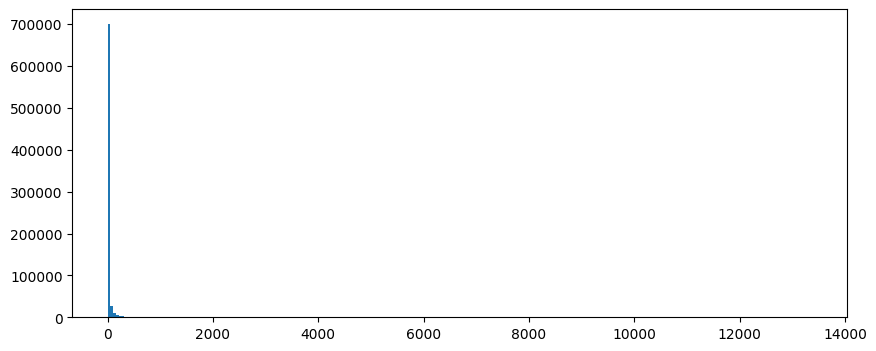

In [177]:
%%time
fig , ax = plt.subplots(figsize = (10 , 4))

ax.hist(twt_df_usr.num_twt , bins = 250);

That's not very enlightening. Let's see if we can do better manually!

In [193]:
%%time
twt_df_usr_2 = twt_df_usr.groupby('num_twt').agg(users = ('user' , 'nunique')).reset_index()
twt_df_usr_2['log_users'] = np.log10(twt_df_usr_2['users'])

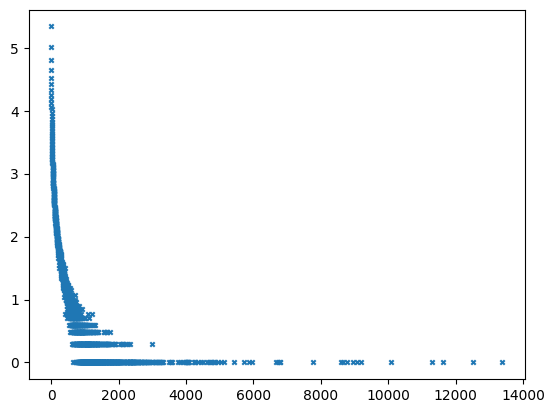

In [199]:
%%time
plt.scatter(twt_df_usr_2['num_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');

We see that this plot roughly agrees with the histogram. It helps us understand that the majority of users tweet between 1 and 2000 times (we will return to quantifying this a little later). <br/>
However, there are *some* users who have tweeted over 10,000 times, with the top user (by volume of tweets) having tweeted 13376 times! <br/>
Seeing that there are 30 days in our dataset, this user must have tweeted
$$
13376

### **JUNK**

In [13]:
hypo_test_df_2 = twt_df.groupby(['ts_day' , 'weekday']).agg(num_tweets = ('tweet_id','nunique')).reset_index()

,ts_day,weekday,num_tweets
0,2022-06-01,1,528203
1,2022-06-02,1,507581
2,2022-06-03,1,504556
3,2022-06-04,0,497624
4,2022-06-05,0,502225


In [26]:
weekday_tweets = list(hypo_test_df_2[hypo_test_df_2['weekday'] == 1]['num_tweets'])
weekend_tweets = list(hypo_test_df_2[hypo_test_df_2['weekday'] == 0]['num_tweets'])

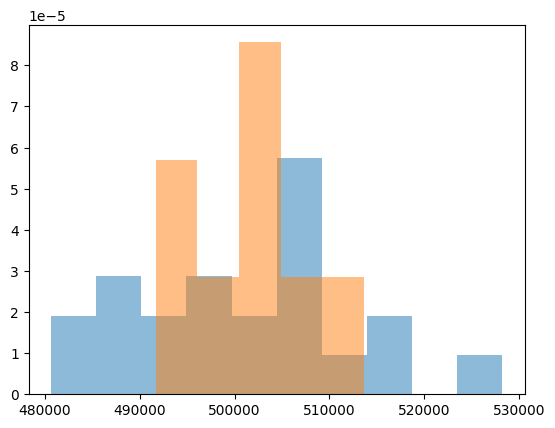

In [60]:
plt.hist(weekday_tweets , density = True , bins = 10 , alpha = 0.5);
plt.hist(weekend_tweets , density = True , bins = 5 , alpha = 0.5);

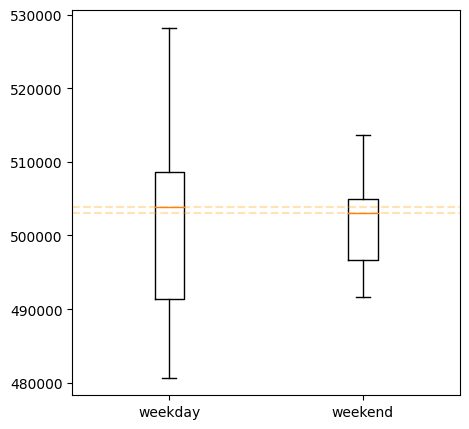

In [75]:
fig , ax = plt.subplots(figsize = (5 , 5))

ax.boxplot([weekday_tweets , weekend_tweets] , whis = 1.5);
ax.set_xticklabels(['weekday', 'weekend']);
ax.hlines(
    [
        np.quantile(a = weekday_tweets , q = 0.5) , 
        np.quantile(a = weekend_tweets , q = 0.5)
    ] , xmin = 0.5 , xmax = 2.5 , ls = "--" , color = 'orange' , alpha = 0.3
    )

In [61]:
np.quantile(a = weekday_tweets , q = [0.0 , 0.5 , 1.0]) , np.quantile(a = weekend_tweets , q = [0.0 , 0.5 , 1.0])

(array([480672., 503878., 528203.]), array([491708., 503052., 513611.]))

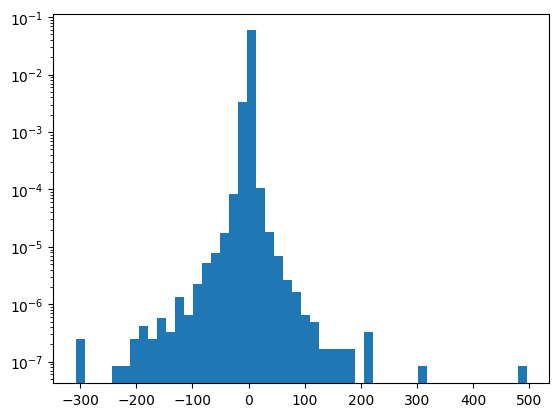

In [7]:
plt.hist(hypo_test_df['mean_diff'] , bins = 50 , density = True);
plt.yscale('log');

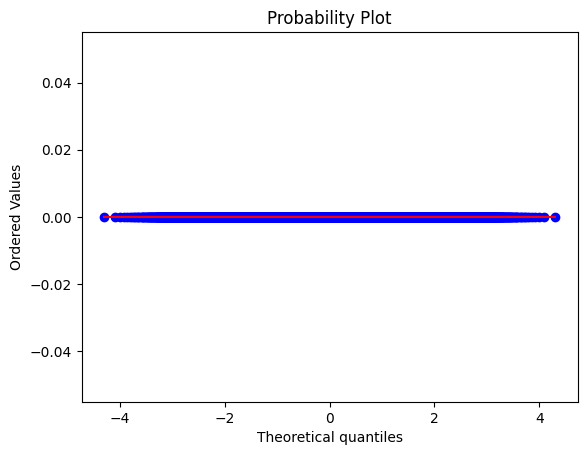

In [8]:
scipy.stats.probplot(np.array(hypo_test_df[
    (hypo_test_df['mean_diff'] == 0)
    # (hypo_test_df['mean_diff'] <= 100)
    ]['mean_diff']) , dist = 'norm' , plot = plt);

# Mann Whitney U Test>?


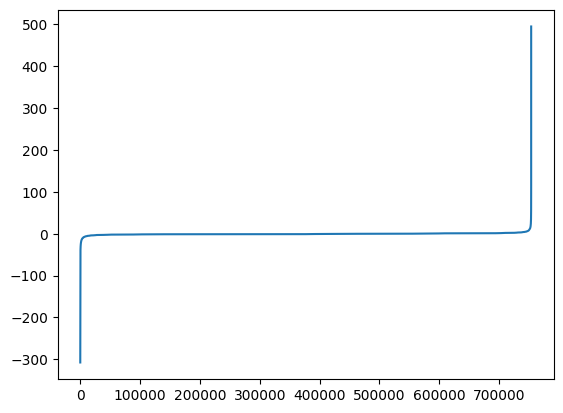

In [9]:
plt.plot(np.sort(np.array(hypo_test_df['mean_diff'])));

In [10]:
a = np.array(hypo_test_df['tweet_0'])
b = np.array(hypo_test_df['tweet_1'])
a = (a - np.mean(a))/np.std(a)
b = (b - np.mean(b))/np.std(b)

KeyError: 'tweet_0'

In [ ]:
scipy.stats.ttest_rel(a , b , alternative = 'two-sided')

Ttest_relResult(statistic=1.6890184098231815e-14, pvalue=0.9999999999999865)

In [ ]:
scipy.stats.ttest_ind(a , b)
# They must be extremely highly positively correlated with each other

Ttest_indResult(statistic=-3.1371699874111226e-15, pvalue=0.9999999999999976)

In [ ]:
scipy.stats.pearsonr(hypo_test_df['tweet_0'] , hypo_test_df['tweet_1'])

PearsonRResult(statistic=0.9086421366777776, pvalue=0.0)

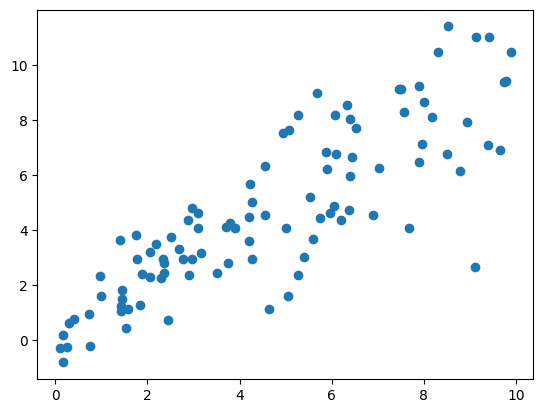

In [ ]:
x = np.sort(np.random.uniform(low = 0 , high = 10 , size = 100))
e1 = np.random.normal(loc = 0 , scale = 1 , size = 50)
e2 = np.random.normal(loc = 0 , scale = 2 , size = 50)

e = np.concatenate([e1, e2] , axis = 0)

y = x + e
# plt.plot(x + e , color = 'olivedrab');
# plt.plot(x);
plt.scatter(x , y)

In [ ]:
scipy.stats.pearsonr( x , y)

PearsonRResult(statistic=0.8428785368208558, pvalue=4.004796890706049e-28)

In [ ]:
scipy.stats.ttest_ind(x , y , alternative = 'two-sided')

Ttest_indResult(statistic=27.090268788814008, pvalue=1.6122573227820088e-68)